In [18]:
#Johanna und Markus, Betreuer, Seminar, Martrikelnummer, WiSe 2020, Uni Augsburg

*DISCLAIMER: Dieses Tutorial verwendet das Codefolding Add-On aus Nbextensions. Sollten Sie dieses nicht installiert haben, empfehlen wir das jetzt zu tun, um das Tutorial bestmöglich nutzen zu können.*

*Unter dem folgenden Link finden Sie eine ausführliche Anleitung
https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/install.html.
Achten Sie darauf den Notebook Server nach der Installation neu zu starten.* 

*Bitte aktivieren Sie die Zeilennummerierung in Ihrem Notebook, indem Sie den Reiter "View" anklicken und "Toogle Line Numbers" auswählen.*

*In diesem Notebook sind einige der Codezellen mit Hilfe des Codefolding eingeklappt. Dieser Code dient der Implementierung und Veranschaulichung des Problems. Für Ihr Verständnis genügt es die ausgeklappten Zellen nachvollziehen zu können. Sie können die eingeklappten Zellen eingeklappt lassen. Wichtig ist, dass Sie alle eingeklappten und ausgeklappten Codezellen der Reihe nach ausführen.*

In [19]:
# Libraries importieren
from copy import deepcopy
import sys
import matplotlib.pyplot as plt
from random import sample, randint, seed
from math import floor, ceil
import ipywidgets as widgets
import IPython as IPy

# Tourenplanung für Ride-Sharing-Dienstleister

Beim Ride-Sharing handelt es sich um eine relativ neue Entwicklung, bei der ein Anbieter einen Transportservice für Kunden zur Verfügung stellt. Dabei unterscheidet sich das Ride-Sharing Konzept von herkömmlichen Taxiunternehmen hautsächlich darin, dass Kunden nicht nacheinander bedient werden. Es ist möglich, dass zwei oder mehr Kunden im Fahrzeug sitzen, wenn sich ihre Routen vereinbaren lassen [1]. Ein Beispiel für einen solchen Ride-Sharing Anbieter ist UberPool [2]. 

Das Tourenplanungsproblem, das sich mit der Planung von Touren für Ride-Sharing-Dienstleister befasst, ist das Dial-a-ride Problem (DARP). Dieses unterscheidet sich von anderen Tourenplanungsproblem zunächst darin, dass sowohl Startorte, als auch Zielorte geplant werden. Außerdem entsteht durch das spezielle Fördergut "Kunde" eine paarweise Verbindung zwischen Startort und Zielort. Im Gegensatz zu einem homogenen Gut, wie Geld, bei dem jeder Zielort von einem beliebigen Startort beliefert werden kann, ist der Kunde ein heterogenes Gut, d.h. jeder Zielort muss vom zugehörigen Startort bedient werden [3]. Zusätzlich ergeben sich durch die Beförderung von Kunden oft weitere, zu berücksichtigende Kriterien, wie z.B. die im Fahrzeug verbrachte Zeit [4].

Eine Standarddefinition des DARP kommt von Cordeau und Laporte [4]:
<center>"In the dial-a-ride problem (DARP), $n$ users specify transportation requests between given origins and destinations. Users may provide a time window on their desired departure or arrival time, or on both. Transportation is supplied by a fleet of $m$ vehicles based at a common depot. The aim is to design a set of least cost vehicle routes capable of accommodating all requests, under a set of constraints." [4, p.1]</center>

Im Weiteren beschäftigen wir uns mit dem dynamischen DARP (DDARP), wie es von Haferkamp und Ehmke [2] vorgestellt wird. Da im dynamischen Fall die zukünftigen Kundenanfragen nicht bekannt sind, müssen beim Eintreffen jeder einzelnen Anfrage zwei Planungsentscheidungen getroffen werden:
  1. Wird der Kunde akzeptiert? $\longrightarrow$ **Akzeptanzentscheidung**
  2. Und wenn ja, wie sieht der neue Routenplan aus? $\longrightarrow$ **Routingentscheidung**

Im dynamischen DDARP von Haferkamp und Ehmke [2] müssen nicht alle Kunden akzeptiert werden, Ziel ist es jedoch die  Akzeptanzrate durch eine effizientere Tourenplanung zu maximieren. Um das zu erreichen, schlagen Haferkamp und Ehmke [2] vor, zukünftige Kundenanfragen zu antizipieren und diese mit in die Planungsentscheidungen einzubeziehen.

Es werden vier Ausprägungen von Antizipation betrachtet:
1. **None Anticipatory/ Myopisch**: Zukünftige Kunden werden nicht beachtet. Jeder Kunde der in den Tourenplan eingefügt werden kann, wird akzeptiert. Der Routenplan wird für alle noch nicht ausgeführten Kunden neu erstellt.
2. **Anticipatory Acceptance**: Zukünftige Kunden werden bei der Akzeptanzentscheidung beachtet. Bei jeder Anfrage wird geprüft, ob sie unter Berücksichtigung zukünftiger Kunden vorteilhaft ist. Wenn nicht, wird sie abgelehnt. Der Routenplan wird für alle noch nicht ausgeführten Kunden neu erstellt.
3. **Anticipatory Routing**: Zukünftige Kunden werden bei der Routingentscheidung beachtet. Jeder Kunde der in den Tourenplan eingefügt werden kann, wird akzeptiert. Annahme: Planung für den nächsten Tag. Bei der Optimierung des Routenplans werden alle Kunden beachtet, auch die die bei einer Planung für den selben Tag schon bedient worden wären. 
4. **Fully Anticipatory**: Kombination aus Anticipatory Acceptance und Anticipatory Routing. Bei jeder Anfrage wird geprüft, ob sie unter Berücksichtigung zukünftiger Kunden vorteilhaft ist. Wenn nicht, wird sie abgelehnt. Bei der Optimierung des Routenplans werden alle Kunden beachtet. Durch die Annahme von perfekter Information kann das Problem statisch gelöst werden.

In Teil 1 beginnen wir mit der detaillierten Problemdefinition für den nicht-antizipatorischen Fall des DDARPs, den wir anhand eines Beispiels veranschaulichen. In Teil 2 folgt die Einführung der zwei für die Problemlösung wesentlichen Methoden, die Large Neighborhood Search (LNS) und die Parallel Insertion-Heuristik. Damit lösen wir unser Beispielproblem. Anschließend folgt in Teil 3 ein Ausblick über weitere Anwendungen des DDARPs.

Bei allem orientieren wir uns, wenn nicht anders angegeben, an Haferkamp und Ehmke [2]. Ziel ist es nicht deren Analyse nachzustellen, sondern ein "Proof of Concept" für ihr Vorgehen zu erhalten.

## Teil 1: Ride-Sharing Problem

Im Folgenden werden die Bausteine des nicht-antizipatorischen Ride-Sharing-Problems eingeführt und durch Beispiele erklärt.

### 1.1 Kundenanfragen

In [20]:
class Request:

    # Klassenübergreifende Zählvariable: Anzahl der erstellten Request-Objekte
    count = 0

    def __init__(self, pickup_loc, dropoff_loc, request_time, alpha):
        # Erzeuge einzigartige ID für jedes Request-Objekt und inkrementiere Zählvariable
        Request.count += 1
        self.id = Request.count
        # Empfangszeit der Anfrage und frühester Abholzeitpunkt beim Startort
        self.request_time = request_time
        # Spätest mögliche Ankunftszeit des Kunden am Zielort
        self.latest_dropoff = request_time + distance(pickup_loc, dropoff_loc) + alpha
        # Zur Anfrage zugehörige Start- und Zielorte
        self.pickup = PickUp(pickup_loc, self)
        self.dropoff = DropOff(dropoff_loc, self)

class PickUp:
    is_pickup = True
    is_dropoff = False

    def __init__(self, loc, request):
        # Koordinaten (num, num) des Startortes
        self.loc = loc
        # Zugehörige Kundenanfrage
        self.request = request

class DropOff:
    is_pickup = False
    is_dropoff = True

    def __init__(self, loc, request):
        # Koordinaten (num, num) des Zielortes
        self.loc = loc
        # Zugehörige Kundenanfrage
        self.request = request

# Distanz (in Zeiteinheiten) zwischen zwei Orten loc1 und loc2
# Hier: euklidische Distanz. Das Funktioninnere kann durch andere Distanzmaße ersetzt werden.
def distance(loc1, loc2):
    return ((loc1[0] - loc2[0])**2 + (loc1[1] - loc2[1])**2)**0.5

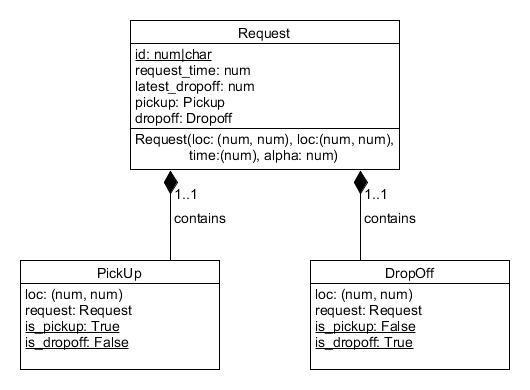

Eine Kundenanfrage $r$ (*request*) ist in der Menge der Kundenanfragen $\mathcal{R}$ ($r \in \mathcal{R}$) enthalten. Jede Kundenanfrage hat eine Anfragezeit $t_r$ (*request time*). Sie beschreibt den Zeitpunkt, zu dem der Kunde eine Anfrage nach einer Fahrt des Ride-Sharing-Anbieters stellt. 

Der Kunde frägt hierbei eine Fahrt von einem Startort $p_r$ (*Pick-Up*) zu einem Zielort $d_r$ (*Drop-Off*) an. Die Orte werden durch Klassen repräsentiert, die die Koordinaten des Ortes ($x, y$) beinhalten.

Die Fahrt muss innerhalb des Zeitfensters [$t_r, m_r$] (*time window*) durchgeführt werden. Der früheste Abholzeitpunkt wird durch die Anfragezeit des Kunden $t_r$ festgelegt. Vorausbuchungen sind somit nicht möglich. Der späteste Ankunftszeitpunkt des Kunden am Zielort $m_r = t_r + c_{p_r,d_r} + \alpha$ ergibt sich aus der Empfangszeit der Anfrage $t_r$, der euklidischen Distanz zwischen dem Start- und dem Zielort $c_{p_r,d_r}$ (*distance*) und $\alpha$. Der Parameter $\alpha$ bezeichnet die vom Kunden maximal tolerierte Verzögerungszeit, die durch Wartezeiten und abweichende Touren durch Bedienung anderer Kunden entsteht. Eine Distanzeinheit entspricht einer Zeiteinheit.

**Beispiel:** Ein Kunde fragt eine Fahrt vom Startort (3, 4) zum Zielort (3, 0) zum Zeitpunkt $r_t=$ 0 an. Es wird angenommen, dass der Kunde eine Verzögerung von $\alpha=$ 30 Zeiteinheiten akzeptiert. Die beiden Orte sind vier Zeiteinheiten voneinander entfernt.

Hieraus ergibt sich, dass die Fahrt innerhalb des Zeitfensters [0, 0 + 4 + 30] = [0, 34] absolivert werden muss.

In [21]:
# Code-Beispiel
bsp_request = Request(pickup_loc=(3, 4), dropoff_loc=(3, 0), request_time=0, alpha=30)
print("Ankunftszeit der Kundenanfrage: "+
     str(bsp_request.request_time))
print("Distanz zwischen Startort und Zielort: " +
     str(distance(bsp_request.pickup.loc, bsp_request.dropoff.loc)))
print("Späteste Ankunft am Zielort: " +
     str(bsp_request.latest_dropoff))

Ankunftszeit der Kundenanfrage: 0
Distanz zwischen Startort und Zielort: 4.0
Späteste Ankunft am Zielort: 34.0


Auf Bedienzeiten, etwa die Einstiegsdauer und die Verifizierung des Kunden wird der Einfachheit halber verzichtet.

### 1.2 Touren

In [22]:
class Tour:

    def __init__(self, depot_loc=(0, 0), M=sys.maxsize):
        # Erstelle Pseudo-Request depot. depot_loc ist Start- und Zielstandort
        depot = Request(depot_loc, depot_loc, 0, M)
        Request.count -= 1
        depot.id = 'D'
        # Tour: Abfolge von Pickups und Dropoffs, Tour beginnt und endet mit dem Depot
        self.tour = [depot.pickup, depot.dropoff]
        # Early: Frühestmögliche und geplante Besuchszeit des Standortes in Tour. 
        self.early = [0, 0]
        # Late: Spätest möglich geplante Besuchszeit
        self.late = [M, M]
        # Length: Länge der Tour
        self.length = 2
        # Gesamtkosten der Tour
        self.total_cost = 0
        # Positionen der Standorte der Tour
        self.dict_place_positions = {}

    # Check: Ist der PickUp/DropOff in Position i der Tour einfügbar?
    def check_insert_feasible(self, place, i):
        p_id = place.request.id
        temp = [(elem.is_pickup, elem.request.id) for elem in self.tour]
        # DropOff muss in die gleiche Tour wie der PickUp eingefügt
        # UND DropOff muss nach dem Pickup eingefügt werden.
        if place.is_dropoff and ((True, p_id) not in temp[:i] or (False, p_id) in temp):
            return False
        # PickUp ist nicht vor dem DropOff einfügbar
        if place.is_pickup and ((False, p_id) in temp[:i] or (True, p_id) in temp):
            return False
        # Die Zeitfenster aller Ort der Tour müssen eingehalten werden. 
        # Verletzt, falls e > l
        e, l = self.insertion_time_window(place, i)
        return e <= l
        
    # Berechne anfallende Einfügekosten, falls Pick-Up / Drop-Off place in Position i eingefügt wird
    def insertion_cost(self, place, i):
        return (distance(self.tour[i-1].loc, place.loc) + distance(place.loc, self.tour[i].loc)
                - distance(self.tour[i-1].loc, self.tour[i].loc))

    # Berechnen des Zeitfensters des Ortes, falls es in die Position i der Tour eingefügt wird
    # Entnommen aus: Campbell and Savelsbergh (2004)ingefügt wird
    def insertion_time_window(self, place, i):
        e = max(place.request.request_time, self.early[i-1]) + distance(self.tour[i-1].loc, place.loc)
        l = min(place.request.latest_dropoff, 
                self.late[i] - distance(place.loc, self.tour[i].loc))
        return e, l

    # Füge den Ort place in Position i der Tour ein
    def insert(self, place, i):
        # aktualisiere die Gesamtkosten der Tour
        self.total_cost += self.insertion_cost(place, i)
        # Einfügen von place in die Position i der Liste tour
        self.tour.insert(i, place)
        # Die Anzahl der Orte der Tour vergrößert sich
        self.length += 1
        # Berechne Zeitfenster des neuen Ortes und füge es in early und late ein
        e, l = self.insertion_time_window(self.tour[i], i)
        self.early.insert(i, e)
        self.late.insert(i, l)
        # Update der Zeitfenster (late) der Orte vor dem neuen Ort
        for k in range(i, -1, -1):
            self.late[k] = min(self.late[k], self.late[k+1] - distance(self.tour[k].loc, self.tour[k+1].loc))
        # Update der Zeitfenster (early) der Orte nach dem neuen Ort
        for k in range(i+1, self.length):
            self.early[k] = max(self.early[k], self.early[k-1] + distance(self.tour[k-1].loc, self.tour[k].loc))
        # Update der Positionen der Orte nach dem neuen Ort im Dictionary:
        for key in self.dict_place_positions:
            if self.dict_place_positions[key] >= i:
                self.dict_place_positions[key] += 1
        # Einfügen der Position des neuen Ortes ins Dictionary
        self.dict_place_positions[place] = i
    
    # entferne den PickUp/DropOff auf Position i der Tour
    def remove(self, i):
        place = self.tour[i]
        # Lösche den Ort place von tour, early, late und dem Dictionary
        del self.tour[i]
        del self.early[i]
        del self.late[i]
        del self.dict_place_positions[place]
        # Reduziere die Gesamtkosten der Tour um die Einfügekosten des entfernten Ortes
        self.total_cost -= self.insertion_cost(place, i)
        # Reduziere die Anzahl der Orte der Tour
        self.length -= 1
        # Berechne die Zeitfenster neu: Early - vorwärts, Late - rückwärts
        for k in range(1, self.length):
            self.early[k] = max(self.tour[k].request.request_time + distance(self.tour[k-1].loc, self.tour[k].loc), 
                self.early[k-1] + distance(self.tour[k-1].loc, self.tour[k].loc))
        for k in range(self.length-2, -1, -1):
            self.late[k] = min(self.tour[k].request.latest_dropoff, 
                self.late[k+1] - distance(self.tour[k].loc, self.tour[k+1].loc))
        # Reduziere die Position im Dictionary für die nachfolgenden Orte
        for key in self.dict_place_positions:
            if self.dict_place_positions[key] >= i:
                self.dict_place_positions[key] -= 1
    
    # Gebe die Kundenanfragen aus, die zum Zeitpunkt time aus der Tour entfernbar sind
    # entfernbar: Kundenanfragen, deren Startort und Zielort nach time liegen UND noch nicht angefahren wurden
    def get_removable_requests(self, time):
        result = []
        # v: Position der Tour, die im Zeitpunkt time als nächstes bedient / angefahren wird
        v = len([e for e in self.early if e <= time])
        # Startort auf Position v => Startort wird als nächstes angefahren und ist somit nicht entfernbar,
        # da der nächste angefahrene Ort nicht abrupt änderbar.
        # Folglich müssen sowohl der Startort, als auch der Zielort > v sein
        for key in self.dict_place_positions:
            if (key.is_pickup 
                and self.dict_place_positions[key] > v 
                and self.dict_place_positions[key.request.dropoff] > v):
                result.append(key.request)
        return result
    
    # Gebe eine Liste aus mit der Abfolge von: (ID, Koordinaten, früheste | geplante Besuchszeit, Art des Ortes)
    def printable(self):
        result = []
        for i in range(self.length):
            if i == 0 or i == self.length-1:
                typ = "D"
            elif self.tour[i].is_pickup:
                typ = "PU"
            else:
                typ = "DO"
            result.append((self.tour[i].request.id, 
                           self.tour[i].loc, 
                           round(self.early[i], 2), 
                           #round(self.late[i], 2), 
                           typ))
        return result

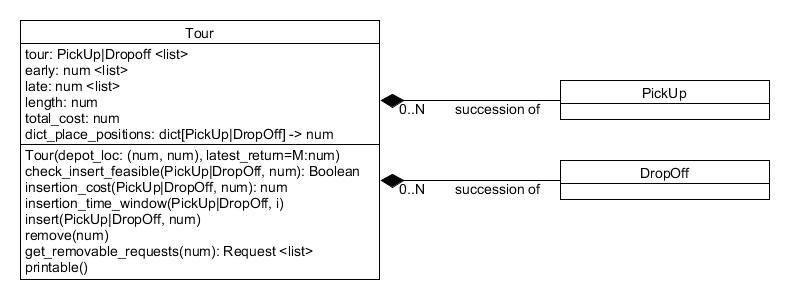

Eine Tour $v$ entspricht der geplanten Fahrt eines Fahrzeugs des Ride-Sharing-Anbieters. Sie ist in der Menge der Touren $\mathcal{V}$ ($v \in \mathcal{V}$) enthalten. Die Kapazität jedes Fahrzeuges ist unbeschränkt und die Fahrzeuge unterscheiden sich nicht voneinander. Auf die Kapazitätsbeschränkung kann verzichtet werden, da die Kundenanfragen kurze Zeitfenster aufweisen und es somit unwahrscheinlich ist, viele Kunden gleichzeitig in einem Fahrzeug unterbringen zu können.

Jede Tour beginnt zum Zeitpunkt 0 und wird mit den Koordinaten der Startposition des Fahrzeugs (*depot*) initialisiert. Die anfängliche geplante Tour besteht aus einer Rundreise, die mit diesem Depot beginnt und endet. Mit dem heuristischen Verfahren werden die Startorte $p_r$ und Zielorte $d_r$ der Kundenanfragen $r$ in die Touren eingefügt (*insert*) und entfernt (*remove*), wobei die Liste *tour* die Abfolge der Orte darstellt. Damit ein Ort in die Tour an einer Position einfügbar ist, muss die Tour zulässig sein (*feasibility check*). 

Zum einen müssen die Zeitfenster jeder einzelnen Kundenanfragen innerhalb der Tour berücksichtigt werden. Hierzu werden die frühesten und spätesten möglichen Besuchszeiten der Orte innerhalb der Tour mit $e_{p_r}, e_{d_r}, l_{p_r}$ und $l_{d_r}$ (*early*, *late*) festgehalten. Die tatsächlich geplante Besuchszeit der Orte $z_{p_r}, z_{d_r}$ entspricht der frühestmöglichen Besuchszeiten $e_{p_r}, e_{d_r}$ (*early*). 

Zudem wird die Anzahl der Orte in der Tour (*length*) und die Gesamtreisezeit der Tour (*total_cost*) festgehalten.

#### 1.2.1 Einfügekosten

Nach der Maximierung der Akzeptanzquote, ist die Minimierung der Gesamtreisedauer (*total_cost*) das zweite Ziel. Bei gleicher Anzahl von akzeptierten Kundenanfragen, wird der Tourenplan mit der geringeren Gesamtreisedauer bevorzugt. Ihre Berechnung erfolgt anhand der Einfügekosten (*insertion_cost*). Beim Einfügen eines neuen Ortes (*neu*) auf die Position $i$ der Tour werden die Einfügekosten wie folgt berechnet und zu den *total_cost* hinzugefügt. 

Gleichung der Einfügekosten:
$c_{insert} = c_{tour_{i-1}, neu} + c_{neu, tour_{i}} - c_{tour_{i-1}, tour_{i}}$ 

**Beispiel:** Mit dem Einfügen des neuen Zielortes (3, 0) auf die Position 2 in die Beispieltour (0, 0), (3, 4), (0, 0) mit der Reisedauer von $total\_cost =$ 10 Zeiteinheiten, ergibt sich die neue Tour (0, 0), (3, 4), (3, 0), (0, 0). 

Die Einfügekosten betragen im Beispiel $c_{(3, 4), (3, 0)} + c_{(3, 0), (0, 0)} - c_{(3, 4), (0, 0)} =$ 4 + 3 - 5 = 2 und die Gesamtreisedauer steigt somit von 10 auf 12 Zeiteinheiten.

In [23]:
# Beispielinstanz erstellen und vorbereiten
bsp_tour = Tour(depot_loc=(0, 0), M=100)
# Füge (3, 4) auf Position 1 ein
bsp_tour.insert(bsp_request.pickup, 1)
print("Gesamtkosten vor Einfügen: ", 
      bsp_tour.total_cost)
print("Einfügekosten (3, 0) in Position 2: ", 
      bsp_tour.insertion_cost(bsp_request.dropoff, 2))
bsp_tour.insert(bsp_request.dropoff, 2)
print("Gesamtkosten nach Einfügen: ", 
      bsp_tour.total_cost)

Gesamtkosten vor Einfügen:  10.0
Einfügekosten (3, 0) in Position 2:  2.0
Gesamtkosten nach Einfügen:  12.0


#### 1.2.2 Zeitfenster

Bei der Erstellung der Touren müssen die Zeitfenster [$t_r, m_r$] aller Kundenanfragen $r$ berücksichtigt werden. So darf ein Startort nicht vor der Anfragezeit $t_r$ angefahren werden und ein Zielort muss spätestens zur spätesten Ankunftszeit $m_r$ bedient werden. Das muss für alle Orte einer Tour gewährleistet werden. Hierfür wird für jeden Ort der Tour das Zeitfenster [$e_{ort}, l_{ort}$] definiert. Die Berechnung erfolgt angelehnt an Campbell und Savelsbergh [5] wie folgt:

$e_{neu} = max(t_{neu}, e_{i-1}) + c_{i-1, neu}$

$l_{neu} = min(m_{neu}, l_i - c_{neu, i})$

Der früheste Besuchszeitpunkt $e_{neu}$ wird in Abhängigkeit der frühesten Besuchszeitpunkt des vorigen Ortes $e_{i-1}$ und der Reisezeit von dem vorigen Ort zum neuen Ort $c_{i-1, neu}$ berechnet. Falls der vorige Kunde bereits besucht wurde und das Fahrzeug beim letzten Ort auf die Ankunft einer neuen Kundenanfrage wartet, ergibt sich die früheste Besuchszeit aus dem Zeitpunkt der neuen Kundenanfrage $t_{neu}$ und der Reisezeit $c_{i-1, neu}$. Hier unterscheidet sich unser Vorgehen von dem von Campbell und Savelsbergh [5], weil sie von einem statischen Problem ausgehen, in dem die frühesten Besuchszeiten $t_r$ aller Kundenanfragen bereits im Vorhinein bekannt sind. Im dynamischen Fall wird die Kundenanfrage erst zum Zeitpunkt $t_r$ bekannt und die Reisezeit $c_{i-1, neu}$ muss somit berücksichtigt werden.

Der späteste Besuch des neuen Ortes $l_{neu}$ muss vor der spätesten tolerierten Ankunftszeit der neuen Kundenanfrage am Zielort $m_{neu}$ und der spätesten möglichen Ankunftszeit des nächsten Ortes $l_i$ unter Berücksichtigung der Reisedauer $c_{neu, i}$ erfolgen. Ist es nicht möglich, die früheste Besuchszeit $e_{neu}$ vor der spätesten Besuchszeit $l_{neu}$ einzubringen ($e > l$), so können die Zeitfenster der anderen Kundenanfragen [$t_r, m_r$] nicht eingehalten werden und die gesamte Tour wäre nicht zulässig.

Zwar ist es möglich, die Orte in jedem Zeitpunkt zwischen [$e_{ort}, l_{ort}$] zu besuchen, ohne dass sich die Durchführbarkeit der Tour und die Gesamtreisedauer ändert, jedoch wird hier angenommen, dass jeder Ort zur frühestmöglichen Besuchszeit $e_{ort}$ besucht wird ($z_{ort} = e_{ort}$). So kann im dynamischen Kontext besser auf zukünftige, unbekannte Kundenanfragen $r$ reagiert werden und es wird eine bessere Kundenzufriedenheit durch geringere Wartezeiten für den Kunden erzielt.

Wird ein neuer Ort auf Position $i$ in die Tour eingefügt, müssen die Zeitfenster [$e_{ort}, l_{ort}$] der anderen Orte wie folgt angepasst werden.

für Position $k = i - 1$ bis $0$:
* $l_k = min(l_k, k_{k+1} - c_{k, k+1})$

für Position $k = i$ bis $n + 1$:
* $e_k = max(e_k, e_{k-1} + c_{k-1, k})$

Auch nach dem Entfernen eines Ortes aus der Tour, werden die Zeitfenster aktualisiert.

**Beispiel:** Ausgehend von der vorigen Tour (0, 0), (3, 4), (3, 0), (0, 0), wird der Startort (0, 4) mit der Ankunftszeit $r_{t}=$ 8 auf Position 2 der Tour gesetzt. Hieraus folgt die neue Tour: (0, 0), (3, 4), (0, 4), (3, 0), (0, 0). 

Die früheste Besuchszeit des vorigen Ortes ist $e_{(3, 4)}=$ 5 und die Distanz vom vorigen Ort zum neuen Ort ist $c_{(3, 4), (0, 4)}=$ 3. Die früheste Besuchszeit des neuen Ortes ergibt sich nun aus $e_{(0, 4)}=$ $max$($t_{neu}, e_{i-1}$) $ + c_{i-1, neu}=$ $max$(8, 5) + 3 = 11. In diesem Fall ist die Ankunftszeit der Anfrage $r_{t}=$ 8 einschränkend. Folglich wartet das Fahrzeug beim Ort (3, 4) drei Zeiteinheiten (Zeitpunkt 5 bis 8) auf den Eingang der neuen Kundenanfrage.

Die späteste Besuchszeit des nächsten Ortes ist $l_{(3, 0)}=$ 34, die Distanz vom vorigen Ort zum neuen Ort ist $c_{(0, 4), (3, 0)}=$ 5 und der späteste Ankunftszeitpunkt beim Zielort ist $m_{(3, 0)} =$ 40. Die späteste Besuchszeit des neuen Ortes ist $l_{(0, 4)}=min$($m_{neu}, l_i - c_{neu, i}$)$ = min$(40, 34 - 5) = 29

Somit ist das Zeitfenster des neuen Ortes [11, 29].

In [24]:
bsp_request = Request(pickup_loc=(0, 4), dropoff_loc=(0, 2), request_time=8, alpha=30)
print("Vor einfügen - e_i: " + 
      str(bsp_tour.early))
print("Vor einfügen - l_i: " + 
      str(bsp_tour.late))
print("Zeitfenster des Ortes (1, 2) in Position 2: " +
     str(bsp_tour.insertion_time_window(bsp_request.pickup, 2)))
bsp_tour.insert(bsp_request.pickup, 2)
print("Nach einfügen - e_i: " + 
      str(bsp_tour.early))
print("Nach einfügen - l_i: " + 
      str(bsp_tour.late))

Vor einfügen - e_i: [0, 5.0, 9.0, 12.0]
Vor einfügen - l_i: [25.0, 30.0, 34.0, 100]
Zeitfenster des Ortes (1, 2) in Position 2: (11.0, 29.0)
Nach einfügen - e_i: [0, 5.0, 11.0, 16.0, 19.0]
Nach einfügen - l_i: [21.0, 26.0, 29.0, 34.0, 100]


#### 1.2.3 Feasibility Check

Damit eine Tour zulässig ist, müssen die folgenden vier Punkte gelten (*feasibility check*):

1. Der Startort und der Zielort einer Kundenanfrage müssen in der gleichen Tour liegen.
2. Der Zielort einer Kundenanfrage muss nach ihrem Startort bedient werden.
3. Bereits zu einem Zeitpunkt bediente Kunden, sowie Kunden, die sich derzeit in einem Fahrzeug befinden und Kunden, die derzeit angefahren werden, können nicht aus der Tour entfernt werden.
4. Die Bedienzeit jedes Ortes muss sich in dem gültigen Zeitfenster [$e_{ort}, l_{ort}$] befinden

**Beispiel :** In die vorige Tour [Depot: (0, 0), Pick-Up_1: (3, 4), Pick-Up_2: (0, 4), Drop-Off_1(3, 0), Depot: (0, 0)] wird der Drop-Off der Kundenanfrage 2 (0, 2) an verschiedenen Positionen eingesetzt.

In [25]:
# Drop-Off_2 (0, 2) auf Position 1 setzen
# False: Pick-Up vor zugehörigem Drop-Off
print("Startort vor Zielort? ", 
      bsp_tour.check_insert_feasible(bsp_request.dropoff, 1))

Startort vor Zielort?  False


In [26]:
# Drop-Off_2 (0, 2) auf Position 1 einer neuen Tour (0, 0), (0, 0) setzen
# False: Drop-Off in einer anderen Tour als der Pick-Up
bsp_tour2 = Tour((0, 0))
print("Startort und Zielort in der gleichen Tour? ", 
      bsp_tour2.check_insert_feasible(bsp_request.dropoff, 1))

Startort und Zielort in der gleichen Tour?  False


In [27]:
# Drop-Off_2 (0, 2) auf Position 3 der ersten Tour setzen
# True: Drop-Off nach dem Pick-Up einsetzbar und Zeitfenster eingehalten
print("Ist die Tour zulässig? ",
      bsp_tour.check_insert_feasible(bsp_request.dropoff, 3))

Ist die Tour zulässig?  True


### 1.3 Entscheidungsepochen

In [28]:
class DecisionEpoch:

    def __init__(self, new_request, tours, beta, gamma1, gamma2):
        # Zeitpunkt der Entscheidungsepoche = Anfragezeitpunkt der neuen Anfrage
        self.time = new_request.request_time
        # Die neue Kundenanfrage
        self.request = new_request
        self.tours = deepcopy(tours)
        # Akzeptanzentscheidung: Wird die neue Kundenanfrage angenommen (accept = True)? 
        self.accept, self.solution = LNS(self, "accept", beta, gamma1, gamma2)
        # Re-Optimierung, falls vorige Kundenanfrage angenommen wurde
        if self.accept:
            self.tours = self.solution
            _, self.solution = LNS(self, "re-routing", beta, gamma1, gamma2)

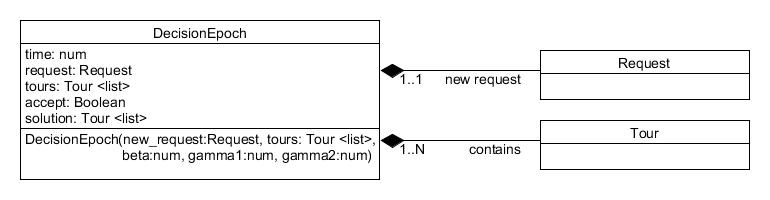

Die Ankunft jeder neuen Kundenanfrage $r_k$ erzeugt eine neue Entscheidungsepoche $k$ ($k \in \mathcal{K}$). Sie ist durch ihren Zeitpunkt *time* charakterisiert, die der Ankunftszeit der neuen Kundenanfrage $t_r$ entspricht. Die Entscheidungsepochen sind für den dynamischen Fall essentiell, da sie jede Stufe des Entscheidungsprozesses abbilden. In der anfänglichen Stufe, die durch die erste Kundenanfrage ausgelöst wird, befinden sich alle Fahrzeuge in ihrem Startzustand am Depot und es gibt keine ausstehenden Kundenanfragen. In jeder neuen Stufe stellt sich die Frage, ob der Ride-Sharing-Anbieter die neue Kundenanfrage annimmt ($accept_k=$ 1), oder ablehnt ($accept_k=$ 0). Zudem muss der Ride-Sharing-Anbieter einen gültigen Tourenplan $y_k$ (*solution*) erstellen, der bis zur nächsten Entscheidungsepoche *k+1* ausgeführt wird. Die Entscheidung in jeder Stufe ist von den bisher getroffenen Entscheidungen in den Vorepochen abhängig. So können für die aktuelle Entscheidung keine bereits akzeptieren Kundenanfragen abgelehnt werden und die Durchführbarkeit der Touren muss gewährleistet bleiben (1.2.3). Bisher bediente Kundenanfragen, die sich in *time* in einem Fahrzeug befinden und Kunden, die derzeit von einem Fahrzeug angefahren werden, können nicht aus einer Tour in eine andere Tour verschoben werden.

### 1.4 Ride-Sharing

In [29]:
class RideSharing:

    # Füge eine neue Kundenanfrage zur Instanz hinzu
    def add_request(self, pickup_loc, dropoff_loc, request_time, alpha):
        self.requests.append(Request(pickup_loc, dropoff_loc, request_time, alpha))

    # Füge eine neue Tour zur Instanz hinzu
    def add_tour(self, depot_loc, latest_return=sys.maxsize):
        self.tours.append(Tour(depot_loc, latest_return))

    # Löse das Problem myopisch
    def solve(self):
        # Sortiere die Kundenanfragen nach ihrer Ankunftszeit und arbeite sie in dieser Reihenfolge ab
        self.requests = sorted(self.requests, key=lambda x: x.request_time)
        for request in self.requests:
            # Neue Kundenanfrage -> neue Entscheidungseopche
            new_epoch = DecisionEpoch(request, self.tours, self.beta, self.gamma1, self.gamma2)
            # Akuteller Routenplan nach dieser Eopche
            self.tours = new_epoch.tours
            self.epochs.append(new_epoch)
            # Wurde die Kundenanfrage in dieser Epoche angenommen?
            if new_epoch.accept == False:
                self.rejected_requests.append(new_epoch.request)
    
    # Scatter-Plot: Koordinaten der Startorte, der Zielorte und der Depots
    def visualize_init_state(self):
        # Ermittle Koordinaten der Startorte, Zielorte und der Depots
        x_pickup = [req.pickup.loc[0] for req in self.requests]
        y_pickup = [req.pickup.loc[1] for req in self.requests]
        x_dropoff = [req.dropoff.loc[0] for req in self.requests]
        y_dropoff = [req.dropoff.loc[1] for req in self.requests]
        x_tour = [tour.tour[0].loc[0] for tour in self.tours]
        y_tour = [tour.tour[0].loc[1] for tour in self.tours]
        # Füge Koordinaten zum Plot hinzu
        plt.plot(x_pickup, y_pickup,'o', label="PickUp")
        plt.plot(x_dropoff, y_dropoff, 'ro', label="DropOff")
        plt.plot(x_tour, y_tour, 'mo', label="TourDepot")
        # Füge Labels hinzu
        for i in range(len(self.requests)):
            plt.text((x_pickup[i]+0.1),(y_pickup[i]+0.1), self.requests[i].id)
            plt.text((x_dropoff[i]+0.1),(y_dropoff[i]+0.1), self.requests[i].id)
        for i in range(len(self.tours)):
            plt.text((x_tour[i]+0.1), (y_tour[i]+0.1), "D")
        # Skaliere Achsen dynamisch
        plt.axis([min(0, *x_pickup, *x_dropoff, *x_tour), max(0, *x_pickup, *x_dropoff, *x_tour)+1,
                min(0, *y_pickup, *y_dropoff, *y_tour), max(0, *y_pickup, *y_dropoff, *y_tour)+1])
        plt.grid()
        plt.legend()
        plt.show()
        
    # Erstelle Gantt-ähnliche Abbildung
    def visualize_tours(self, k=None, height=10):
        # Wahl: Den Tourenplan welcher Entscheidungsepoche darstellen
        # Standard: Tourenplan der letzten Epoche
        if k is None:
            k = len(self.epochs) - 1
        tours_temp = self.epochs[k].solution
        # Erstelle mehrere Plots (# Anzahl Touren + 1 (für abgelehnte Touren))
        fig, axs = plt.subplots(len(tours_temp)+1, figsize=(20, len(tours_temp)*4))
        # aktuelle Position des neuen Balkens
        current_y_pos = 5
        # Skalierung: Einheitliche Achsen für Subplots
        max_end_t = 0
        # Ein Subplot für jede Tour
        for i in range(len(tours_temp)):
            # Position der Kundenanfragen, Label
            y_ticks = []
            y_ticklabels = []
            requests_temp = []
            # Beschriftung der Tour: Nummer der Tour und Koordinaten
            tour_loc = tours_temp[i].tour[0].loc
            axs[i].set_ylabel(str(i+1) + ": " + str(tour_loc))
            # Ermittle Kundenanfragen der Tour
            for j in range(1, tours_temp[i].length-1):
                if tours_temp[i].tour[j].is_pickup:
                    requests_temp.append(tours_temp[i].tour[j].request)
            requests_temp = sorted(requests_temp, key=lambda x: x.request_time, reverse=True)
            # Ermittle Eigenschaften jeder Kundenanfragen für die Beschriftung
            for req in requests_temp:
                req_t = req.request_time
                end_t = req.latest_dropoff
                # für X-Achsen-Skalierung
                if end_t > max_end_t:
                    max_end_t = end_t
                pu_t = tours_temp[i].early[tours_temp[i].dict_place_positions[req.pickup]]
                do_t = tours_temp[i].early[tours_temp[i].dict_place_positions[req.dropoff]]
                r_id = req.id
                pu_loc = req.pickup.loc
                do_loc = req.dropoff.loc
                # Füge neues unterbrochenes Barchart hinzu
                # orange: Zeit vor Bearbeitung (Anfragezeit, Bedienzeit Startort)
                # blau: Zeit (Fahrzeit Startort zum Zielort)
                # orange2: Zeit nach Bearbeitung (Ankunft Zielort, letztmöglicher Ankunftszeitpunkt)
                axs[i].broken_barh([(req_t, pu_t-req_t), (pu_t, do_t-pu_t), (do_t, end_t-do_t)],
                                   (current_y_pos, height-1),
                                   facecolors=("tab:orange", "tab:blue", "tab:orange"))
                y_ticks.append(current_y_pos + 0.5*height)
                y_ticklabels.append("id:" + str(r_id) + ": " + str(pu_loc) + " " + str(do_loc))
                current_y_pos += height
            axs[i].set_yticks(y_ticks)
            axs[i].set_yticklabels(y_ticklabels)
        # Visualisiere die abgelehnten Kundenanfragen
        axs[i+1].set_ylabel("rejected requests")
        sorted_rejects = sorted(self.rejected_requests, key=lambda x: x.request_time, reverse=True)
        sorted_rejects = [rej for rej in sorted_rejects if self.epochs[k].time >= rej.request_time]
        y_ticks = []
        y_ticklabels = []
        for reject in sorted_rejects:
            r_id = reject.id
            req_t = reject.request_time
            end_t = reject.latest_dropoff
            pu_loc = reject.pickup.loc
            do_loc = reject.dropoff.loc
            axs[i+1].broken_barh([(req_t, end_t-req_t)],
                               (current_y_pos, height-1),
                               facecolors="tab:orange")
            # für X-Achsen-Skalierung
            if end_t > max_end_t:
                max_end_t = end_t
            y_ticks.append(current_y_pos + 0.5*height)
            y_ticklabels.append("id:" + str(r_id) + ": " + str(pu_loc) + " " + str(do_loc))
            current_y_pos += height
        axs[i+1].set_yticks(y_ticks)
        axs[i+1].set_yticklabels(y_ticklabels)
        # x-Achsenskalierung dynamisch
        for ax in axs:
            ax.set_xlim(0, max_end_t*1.03)
        plt.show()
        
    def __init__(self, beta, gamma1, gamma2):
        Request.count = 0
        self.requests = []
        self.tours = []
        self.epochs = []
        self.rejected_requests = []
        self.beta = beta
        self.gamma1 = gamma1
        self.gamma2 = gamma2

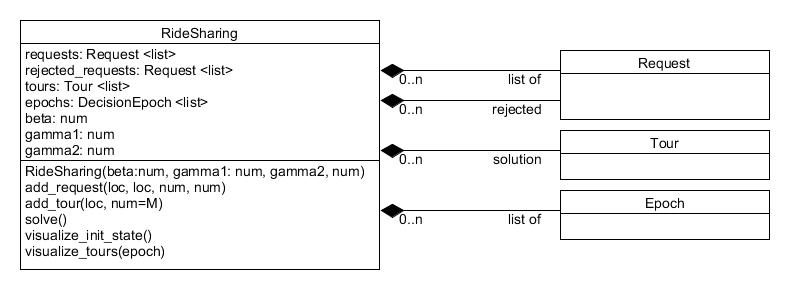

Die Klasse Ride-Sharing dient zur Repräsentation einer Instanz des Ride-Sharing-Problems und als Schnittstelle für den Benutzer. Er kann über den Aufruf *add_request* Kundenanfragen und *add_tour* Touren anlegen und zur Instanz hinzufügen. So kann der Benutzer alle für das Problem relevanten Parameter, inklusive der Hyperparameter der LNS, $\beta$, $\gamma_1$ und $\gamma_2$, eingeben und über die Funktion *solve* den nicht-antizipatorischen Fall des DDARPs für die gewählte Instanz lösen.

In der *solve*-Funktion wird das Problem aus Sicht des Ride-Sharing-Anbieters gelöst. Die Kundenanfragen werden aufsteigend nach ihrer Ankunftszeit $t_r$ sortiert und für jede Kundenanfrage wird eine neue Entscheidungsepoche erstellt. In jeder Entscheidungsepoche wird entschieden, ob der Ride-Sharing-Anbieter die Kundenanfrage annimmt und falls ja, wird der Routenplan optimiert. Ziel ist es, über alle Entscheidungsepochen die Akzeptanzquote der Kundenanfragen zu maximieren und bei gleicher Akzeptanzquote, die Gesamtreisedauer zu minimieren.

### 1.5 Globales Beispiel

Für unser globale Beispielinstanz verwenden wir zwei Fahrzeuge, die an den Orten (1, 1) und (6, 6) zum Zeitpunkt 0 starten. Außerdem legen wir die vier Kunden aus der folgenden Tabelle an. Alle Kunden tolerieren eine Verzögerung von 15 Zeiteinheiten.


Kunde | PickUp  | DropOff | Request Time | End Time | alpha
:--|:---------:|:---------:|:---------:|:---------:|:---------:
1|(1,8)   | (5,9) |0|14.12|15 
2|(3,2)   | (8,5) |0|15.83|15
3|(6,5)   | (3,4) |1|14.16|15
4|(15,15) | (7,1) |3|36.02|15

Führen Sie die folgende Zelle aus, um unsere Instanz des Ride-Sharing-Problems anzulegen.

In [45]:
instance = RideSharing(beta=10, gamma1=0.2, gamma2=0.8)
instance.add_tour(depot_loc=(1, 1))
instance.add_tour((6, 6))
instance.add_request(pickup_loc=(1, 8), dropoff_loc=(5, 9), request_time=0, alpha=15)
instance.add_request((3, 2), (8, 5), 0, 15)
instance.add_request((6, 5), (3, 4), 1, 15)
instance.add_request((15, 15), (7, 1), 3, 15)

Ein kurzer Überblick über die Standorte:

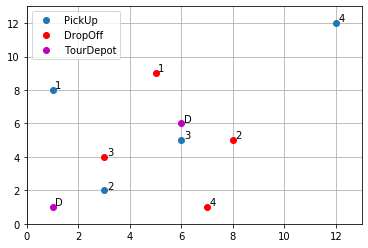

In [31]:
instance.visualize_init_state()

In [32]:
# Führen Sie diese Zelle aus, belegen Sie die Parameter und fügen Sie den Kunden 5 hinzu

style = {'description_width': '130px'}
xo = widgets.BoundedIntText(value=7, min=0, step=1,description='X-Koordinate PickUp',disabled=False, style=style)
yo = widgets.BoundedIntText(value=5, min=0, step=1,description='Y-Koordinate PickUp',disabled=False, style=style)
xd = widgets.BoundedIntText(value=4, min=0, step=1,description='X-Koordinate DropOff',disabled=False, style=style)
yd = widgets.BoundedIntText(value=3, min=0, step=1,description='Y-Koordinate DropOff',disabled=False, style=style)
rt = widgets.BoundedIntText(value=2, min=0, step=1,description='Request Time',disabled=False, style=style)

button = widgets.Button(description="Hinzufügen")

def on_button_clicked(b):
    instance.add_request((xo.value, yo.value), (xd.value, yd.value), rt.value, 15)

button.on_click(on_button_clicked)

display( xo, yo, xd, yd, rt,  button)

BoundedIntText(value=7, description='X-Koordinate PickUp', style=DescriptionStyle(description_width='130px'))

BoundedIntText(value=5, description='Y-Koordinate PickUp', style=DescriptionStyle(description_width='130px'))

BoundedIntText(value=4, description='X-Koordinate DropOff', style=DescriptionStyle(description_width='130px'))

BoundedIntText(value=3, description='Y-Koordinate DropOff', style=DescriptionStyle(description_width='130px'))

BoundedIntText(value=2, description='Request Time', style=DescriptionStyle(description_width='130px'))

Button(description='Hinzufügen', style=ButtonStyle())

Ein Überblick der Orte mit Kunde 5:

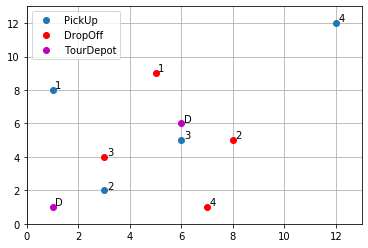

In [33]:
instance.visualize_init_state()

## Teil 2: Heuristisches Lösungverfahren für das DDARP

Im nächsten Schritt lernen wir die Methoden kennen, die wir für die Lösung unseres nicht-antizipatorischen DDARPs brauchen.

### 2.1 Parallel Insertion

Unsere Parallel Insertion-Heuristik arbeitet nach dem Best Insertion-Prinzip. Es wird versucht den "besten" Kunden, an der "besten" Stelle, in der "besten" Tour einzufügen. Das genaue Vorgehen schauen wir uns Schritt für Schritt für die erste Iteration an.

In [34]:
pOpt = 1000 # große Zahl M
tours = instance.tours
requests = instance.requests

Wir beginnen mit dem ersten Kunden *j* = 0  und dem ersten Fahrzeug *k* = 0 im Tourenplan. Zunächst wird die frühestmögliche Einsetzposition in die Tour von Fahrzeug *k* gesucht. Dabei geht man davon aus, dass der Kunde nur nach allen zu diesem Zeitpunkt bereits bedienten Kunden eingefügt werden kann. Außerdem wird das Fahrzeug immer zuerst den Ort anfahren, zu dem es aktuell unterwegs ist. Ist die Tour beispielsweise die folgende Liste an Orten: [0,1,2,3,4,5] und das Fahrzeug ist aktuell zu Ort 3 unterwegs, dann kann der neue Kunde frühestens an Position 4 eingefügt werden.

In [35]:
j = 0 
k = 0 
time = 1 # Zeitpunkt der Anfrage
print("Erste mögliche Position: ", 
      min(len([e for e in tours[k].early if e <= time])+1, tours[k].length-1))

Erste mögliche Position:  1


Als nächstes wird mit dem Feasibility-Check geprüft, ob der Startort des Kunden an dieser Position *spos* = 1 eingefügt werden kann. Wenn ja: Welche Einfügekosten entstehen daraus? 

In [36]:
spos = 1 # Einfügeposition PickUp
print("Feasibility Check: ",
      tours[k].check_insert_feasible(requests[j].pickup, spos))

if tours[k].check_insert_feasible(requests[j].pickup, spos):
    skosten = tours[k].insertion_cost(requests[j].pickup, spos)
    
    print("Einfügekosten Startort: ", skosten)

Feasibility Check:  True
Einfügekosten Startort:  14.0


Da der Feasibility-Check für den Startort des Kunden erfolgreich war, wird dieser vorübergehend an Position 1 in die Tour von *k* eingesetzt. Dafür wird eine temporäre Variable belegt, die dazu dient, alle möglichen Zielort-Positionen für diese Startort-Position überprüfen zu können.

In [37]:
tour_temp = deepcopy(tours[k])
tour_temp.insert(requests[j].pickup, spos)

Als nächstes wird überprüft, ob der Zielort an der nächsten Position *epos* = 2 einfügt werden kann. Auch hier werden die Einfügekosten berechnet.

In [38]:
epos = 2 # Einfügeposition DropOff
print("Feasibility Check:",
      tour_temp.check_insert_feasible(requests[j].dropoff, epos))

if tour_temp.check_insert_feasible(requests[j].dropoff, epos):  
    ekosten = tour_temp.insertion_cost(requests[j].dropoff, epos)
    
    print("Einfügekosten Zielort: ", ekosten)

Feasibility Check: True
Einfügekosten Zielort:  6.067377535616821


Wurde der Startort und der Zielort erfolgreich eingefügt, wird überprüft, ob die Gesamteinfügekosten kleiner als das aktuelle Optimum sind. Wenn dem so ist, werden der aktuelle "beste" Kunde, die "beste" Tour, die "besten" Positionen für den Startort und den Zielort, sowie die Gesamteinfügekosten, als das aktuelle Optimum gespeichert. Das Optimum der Gesamtkosten wird als sehr große Zahl *pOpt* initialisiert.

In [39]:
if skosten + ekosten < pOpt:
    reqOpt = j
    print("Kunde: ", reqOpt)
    
    tourOpt = k
    print("Fahrzeug: ", tourOpt)
    
    sposOpt = spos
    print("Einfügeposition Startort: ", sposOpt)
    
    eposOpt = epos
    print("Einfügeposition Zielort: ", eposOpt)
    
    pOpt = skosten + ekosten
    print("Gesamtkosten", pOpt)     

Kunde:  0
Fahrzeug:  0
Einfügeposition Startort:  1
Einfügeposition Zielort:  2
Gesamtkosten 20.06737753561682


Dieses Verfahren wird wiederholt, bis für alle einzufügenden Kunden, alle möglichen Fahrzeuge und alle möglichen Einfügepositionen für die Startorte und Zielorte überprüft wurden. Dabei werden immer, wenn ein neues Optimum gefunden wurde, alle zugehörigen Werte überspeichert.
Wurden alle Kunden überprüft, so wird der "optimale" Kunde an der "optimalen" Position im "optimalen" Fahrzeug eingesetzt und aus der Liste der offenen Kunden entfernt.
Das Verfahren wird solange wiederholt, bis alle Kunden eingefügt sind oder kein Kunde mehr eingefügt werden kann. Ein Kunde kann nicht eingefügt werden, wenn kein zulässiger Tourenplan gefunden wurde, der den Kunden enthält. Sind am Ende des Verfahrens noch Kunden in der Liste, ohne das ein Optimum kleiner einer großen Zahl *M* gefunden wird, werden diese Kunden abgelehnt.

Wenn wir das alles zusammenführen erhalten wir die Funktion der Parallel Insertion-Heuristik.

In [40]:
def parallel_insertion(tours, requests, time=0, M=sys.maxsize):
    reject = []
    
    while requests:
        pOpt = M 
        for j in range(len(requests)):
            for k in range(len(tours)):
                earl_pos = min(len([e for e in tours[k].early if e <= time])+1, tours[k].length-1)
                # spos: Position in Tour k, an der der PickUp des Kunden eingefügt wird
                for spos in range(earl_pos, tours[k].length):
                    if tours[k].check_insert_feasible(requests[j].pickup, spos):
                        skosten = tours[k].insertion_cost(requests[j].pickup, spos)
                        
                        # Speichere die aktuell gültige Tour in einer temporären Variablen
                        tour_temp = deepcopy(tours[k])
                        
                        # Füge den PickUp des Kunden vorübergehend in den Tourenplan ein 
                        # und aktualisiere die Zeitfenster
                        tour_temp.insert(requests[j].pickup, spos)
                        
                        # Prüfe für alle Positionen im Tourenplan nach dem eingefügten PickUp, 
                        # ob es einen möglichen DropOff gibt 
                        for epos in range(spos+1, tour_temp.length): 
                            if tour_temp.check_insert_feasible(requests[j].dropoff, epos):  
                                ekosten = tour_temp.insertion_cost(requests[j].dropoff, epos)
                                # Überprüfen: Neues Optimum gefunden?
                                if skosten + ekosten < pOpt:
                                    reqOpt = requests[j] 
                                    tourOpt = tours[k] 
                                    sposOpt = spos
                                    eposOpt = epos
                                    pOpt = skosten + ekosten   
      
        if pOpt < M:   
            # Setze den PickUp und DroOff des Kunden ein und aktualisiere die Zeitfenster
            tourOpt.insert(reqOpt.pickup, sposOpt)
            tourOpt.insert(reqOpt.dropoff, eposOpt)
            
            # Entferne den eingesetzten Kunden aus der Liste der noch ausstehenden Kunden
            requests.remove(reqOpt)         
        else:
            # Wenn kein Kunde den Feasibility-Check mehr besteht, speichere die abgewiesenen Kunden 
            # und leere die Liste der offenen Kunden
            reject = deepcopy(requests)
            requests = []
   
    return tours, reject

### 2.2 Large Neighbourhood Search

Für die Lösung unseres nicht-antizipatorischen DDARPs, wird für jede neue Kundenanfrage zuerst entschieden, ob sie akzeptiert werden kann. Hierfür prüfen wir, ob es einen zulässigen Tourenplan gibt, der den neuen Kunden enthält. Konnte kein zulässiger Tourenplan gefunden werden, wird der Kunde abgelehnt. Wurde der Kunde akzeptiert, muss als nächstes entschieden werden, wie der neue Tourenplan aussieht. Dafür wird der zulässige Toureplan re-optimiert. Für beide Entscheidungen verwenden wir eine LNS. Dabei ändern wir nur das Abbruchkriterium. Für die Akzeptanzentscheidung wird die LNS solange wiederholt, bis eine zulässige Lösung gefunden wurde oder eine maximale Anzahl an Iterationen $\beta$ erreicht ist. Wurde eine zulässige Lösung gefunden, wird der Kunde akzeptiert. Bei der Routingentscheidung werden immer $\beta$ Iterationen durchgeführt. Es wird nach der Lösung für den Tourenplan $w_{best}$ gesucht wird, die alle Kunden bedient und die Gesamtreisezeit minimiert.

In der LNS werden abwechselnd ein Destroy-Operator und ein Repair-Operator verwendet. Man beginnt mit einer zulässigen Lösung für den Tourenplan $w_0$. Diese Lösung wird im ersten Schritt mit dem Destroy-Operator teilweise zerstört, indem Kunden aus dem Plan entfernt werden. Im zweiten Schritt wird versucht, mit dem Repair-Operator eine neue zulässige Lösung $w_{new}$ zu generieren, indem alle entfernten Kunden und der neue Kunde in den Tourenplan eingesetzt werden. Ist die Lösung $w_{new}$ besser als die vorherig beste Lösung $w_{best}$, wird sie als neue beste Lösung gespeichert. 
Das Verfahren wird solange wiederholt, bis ein Abbruchkriterium erfüllt ist. Dabei wird immer die letzte zulässige Lösung $w_{new}$ als neue Grundlage für den Destroy-Operator verwendet. Als Ergebnis gibt die LNS die beste Lösung aus, die bis dahin gefunden wurde. 

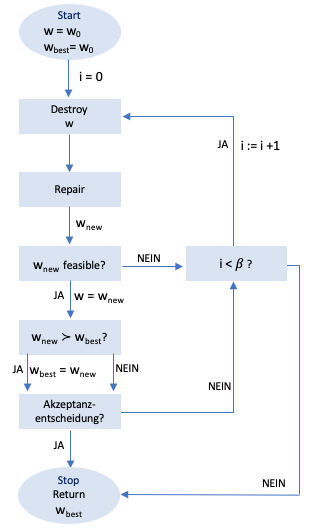

Für die Destroy- und Repair-Operatoren gibt es mehrere Optionen. Als Destroy-Operator verwenden wir das Random-Removal-Verfahren, das zwischen $\gamma_1$ und $\gamma_2$ Prozent der noch nicht ausgeführten Kunden aus dem Tourenplan entfernt. Für den Repair-Operator verwenden Haferkamp und Ehmke [2] eine Regret-2 Insertion. Wir verwenden stattdessen eine Best-Insertion in Form der oben beschriebenen Parallel Insertion-Heuristik.

In [41]:
# Entferne zufällig zwischen gamma1 und gamma2 der entfernbaren Kundenanfragen und setze sie neu ein
def random_removal(tours, time, gamma1, gamma2):
    new_tours = deepcopy(tours)
    candidates = []
    # Ermittle entfernbare Kundenanfragen
    for i in range(len(new_tours)):
        for elem in new_tours[i].get_removable_requests(time):
            candidates.append((i, elem))
    removed = []
    # q: Anzahl der Kundenanfragen, die entfernt werden können
    q = len(candidates)
    # n: Anzahl der Kundenanfragen, die entfernt werden
    n = randint(floor(gamma1 * q), ceil(gamma2 * q))
    # Auswahl: Welche Kundenanfragen entferne ich zufällig
    to_remove = sample(candidates, n)
    # entferne Kundenanfragen
    for elem in to_remove:
        pos_pickup = new_tours[elem[0]].dict_place_positions[elem[1].pickup]
        pos_dropoff = new_tours[elem[0]].dict_place_positions[elem[1].dropoff]
        new_tours[elem[0]].remove(pos_dropoff)
        new_tours[elem[0]].remove(pos_pickup)
        removed.append(elem[1])
    return new_tours, removed

In [42]:
def LNS(epoch, type, beta, gamma1, gamma2):
    # w = w0
    plan_current = deepcopy(epoch.tours)
    # wbest = w0
    plan_best = deepcopy(epoch.tours)
    if type == "accept":
        unplanned = [epoch.request]
    else:
        unplanned = []
    all_inserted = False
    iteration = 0
    while iteration < beta:
        iteration += 1
        # w_new erzeugen
        plan_new, removed = random_removal(plan_current, epoch.time, gamma1, gamma2)
        unplanned += removed
        # füge entfernte Kundenanfragen und, falls noch nicht geschehen, neue Kundenanfrage ein
        plan_new, reject = parallel_insertion(plan_new, unplanned, epoch.time)
        # Gültigkeit: Alle Kundeneinfragen eingefügt
        if len(reject) == 0 and type == "accept":
            # Akzeptanzentscheidung --> w_best gefunden
            return True, plan_new
        elif len(reject) == 0 and type == "re-routing":
            # Tourenplan ist gültig -> w = w_new
            plan_current = plan_new
            cost_current = sum([tour.total_cost for tour in plan_current])
            cost_best = sum([tour.total_cost for tour in plan_best])
            # Falls geringere Gesamtreisezeit -> w_best = w_new
            if cost_current < cost_best:
                plan_best = plan_new
    return all_inserted, plan_best

Wir haben jetzt alle Bausteine unserer Lösungsverfahrens eingeführt und können damit unsere Beispielinstanz lösen.

In [46]:
instance.solve()
for tour in instance.tours:
    print(tour.printable())
# ID, Koordinaten, early, late, typ

[('D', (1, 1), 0, 'D'), (2, (3, 2), 2.24, 'PU'), (2, (8, 5), 8.07, 'DO'), (5, (7, 5), 9.07, 'PU'), (3, (6, 5), 10.07, 'PU'), (5, (4, 3), 12.9, 'DO'), (3, (3, 4), 14.31, 'DO'), ('D', (1, 1), 17.92, 'D')]
[('D', (6, 6), 0, 'D'), (1, (1, 8), 5.39, 'PU'), (1, (5, 9), 9.51, 'DO'), ('D', (6, 6), 12.67, 'D')]


Im Folgenden werden die Touren und die abgelehnten Kundenanfragen nach jeder Entscheidungsepoche visualisiert. Dabei zeigt ein Subplot die zu einer Tour gehörigen Kundenanfragen. Der letzte Subplot zeigt alle bisher abgelehnten Kundenanfragen. Auf der $x$-Achse ist der Zeitverlauf abgebildet und auf der $y$-Achse stellt ein Balken eine Kundenanfrage dar. Die orangene Fläche gibt das Zeitfenster [$t_r, m_r$] des Kunden wider. Die Fahrt vom Startort bis zum Zielort muss innerhalb der orangenen Fläche liegen und wird durch die blaue Fläche dargestellt.

Epoche: 1  Kundenanfrage: 1 (1, 8) (5, 9)  t = 0  Akzeptanz: True


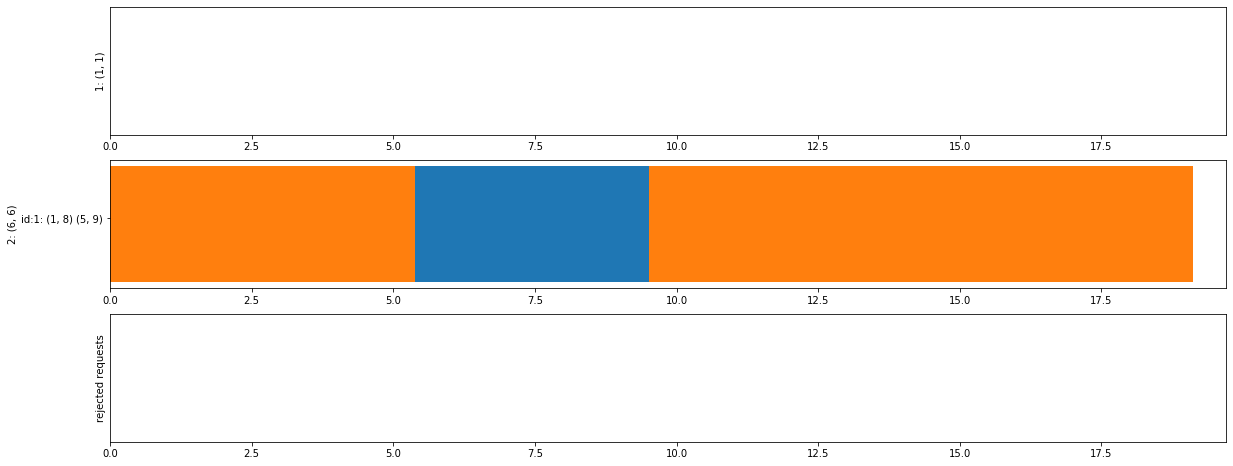

Epoche: 2  Kundenanfrage: 2 (3, 2) (8, 5)  t = 0  Akzeptanz: True


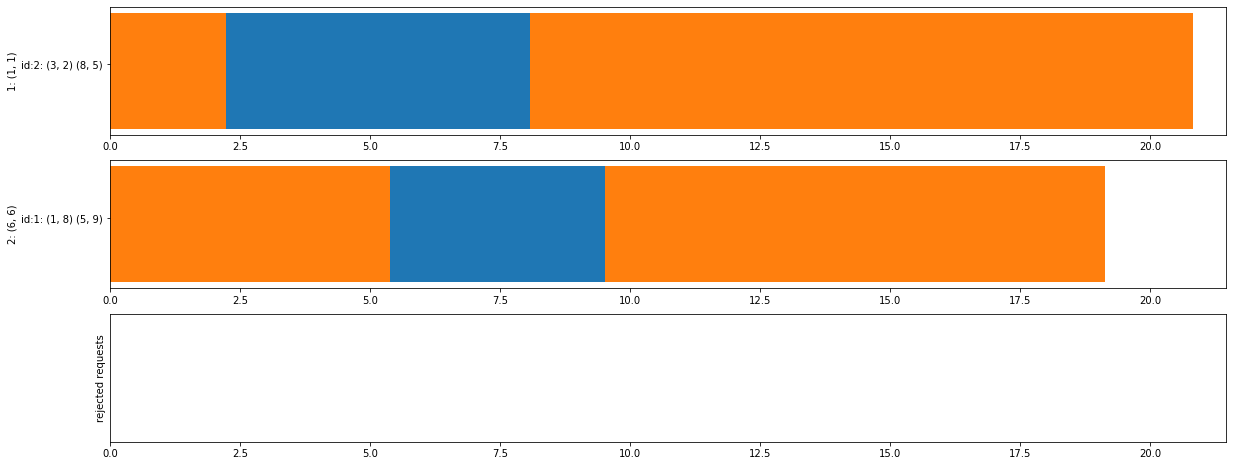

Epoche: 3  Kundenanfrage: 3 (6, 5) (3, 4)  t = 1  Akzeptanz: True


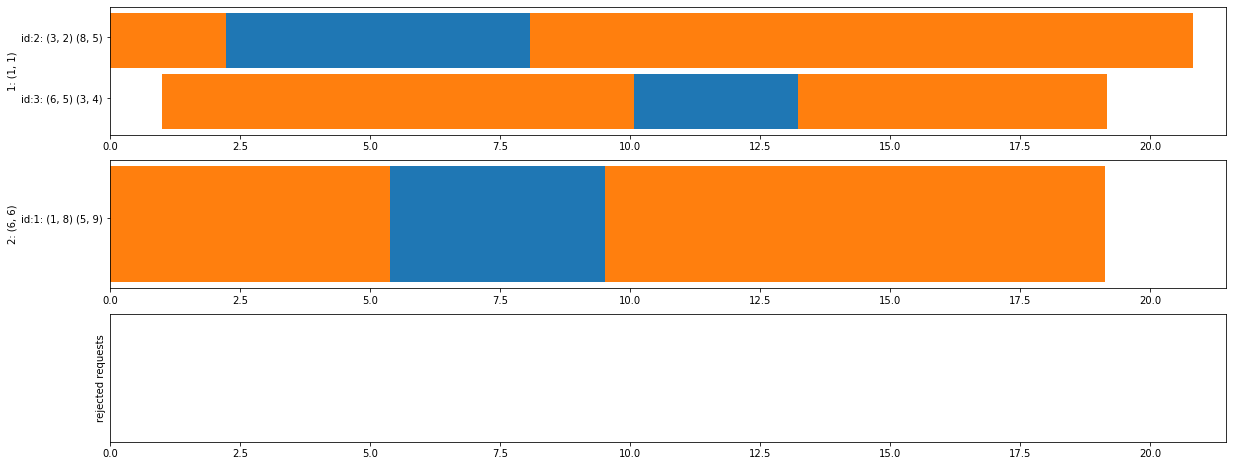

Epoche: 4  Kundenanfrage: 5 (7, 5) (4, 3)  t = 2  Akzeptanz: True


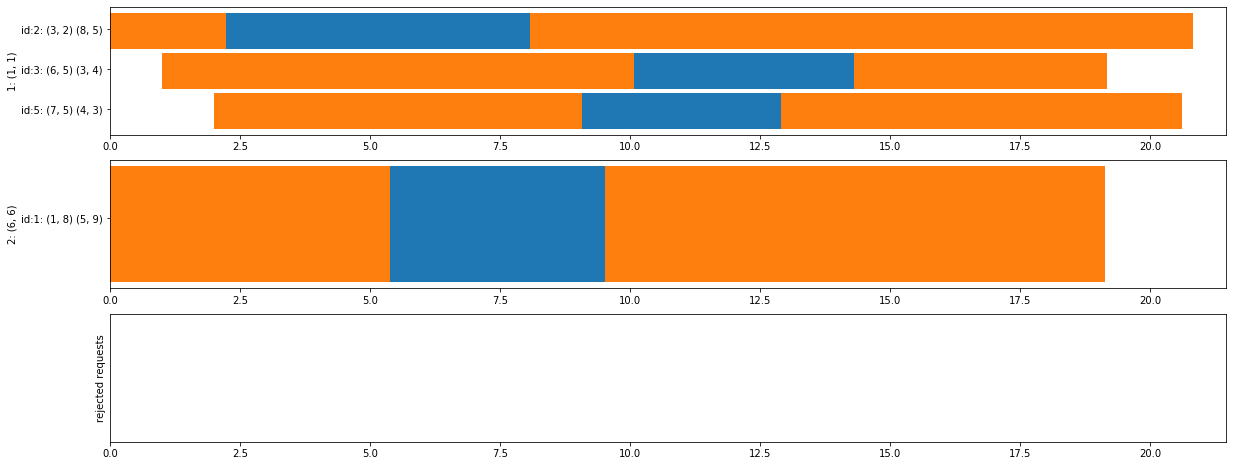

Epoche: 5  Kundenanfrage: 4 (15, 15) (7, 1)  t = 3  Akzeptanz: False


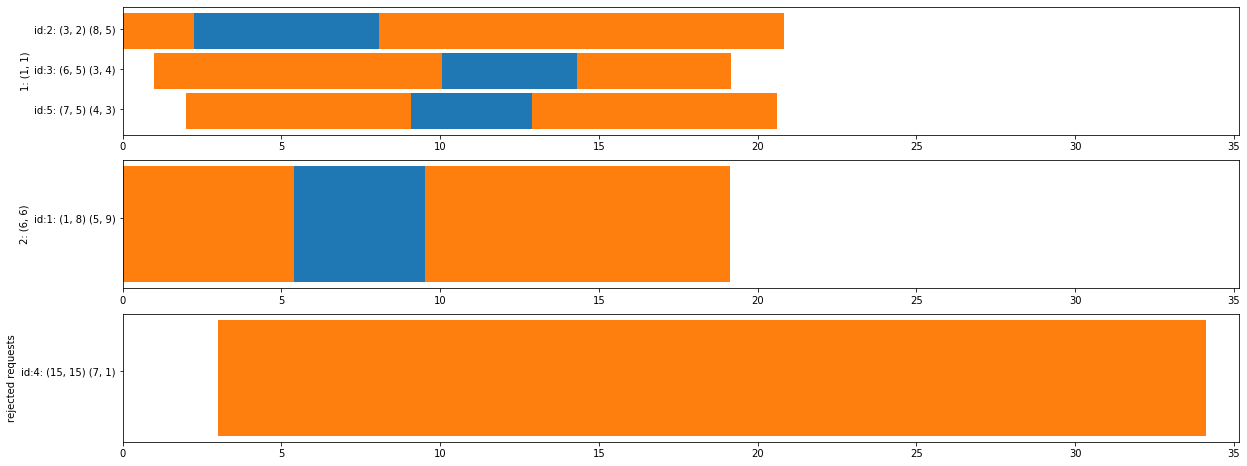

In [47]:
for i in range(len(instance.epochs)):
    print("Epoche: " + str(i+1)
          + "  " + "Kundenanfrage: " 
          + str(instance.epochs[i].request.id) + " "
          + str(instance.epochs[i].request.pickup.loc) + " "
          + str(instance.epochs[i].request.dropoff.loc) + "  t = "
          + str(instance.epochs[i].request.request_time) + "  Akzeptanz: "
          + str(instance.epochs[i].accept)
         )
    instance.visualize_tours(i)

## Teil 3: Ausblick

Wir haben in diesem Notebook nur eine der vielen möglichen Ausprägungen des DDARPs implementiert. Für zuküftige Projekte wäre es sicher sinnvoll, sich mit unterschiedlichen Versionen des DDARPs zu beschäftigt und sie zu vergleichen.

Zunächst kann das Ausprägung der Antizipation verändert werden. Wie bereits zuvor erwähnt, berücksichtigen die Autoren noch drei weitere Ausprägungen der Antizipation: Anticipatory Acceptance, Anticipatory Routing und Fully Anticipatory. Unsere Implementation kann als Basis für diese Modelle verwendet werden.

Für die Anticipatory Acceptance wird für die Akzeptanzentscheidung zusätzlich zum Feasibility-Check ein statisches team orienteering problem (TOP) als Favourability-Check gelöst, um zu prüfen, welche Kunden am vorteilhaftesten sind. Die Routingentscheidung wird jedoch nicht antizipativ getroffen. Es können im Tourenplan nur Kunden vertauscht werden, die noch nicht bedient wurden.

Das Anticipatory Routing ist unserer nicht-antizipativen Modell am ähnlichsten. Der wesentliche Unterschied besteht darin, dass der Tourenplan nicht im Anschluss an jede Akzeptanzentscheidung optimiert wird, sondern erst wenn alle akzeptierten Anfragen feststehen. Es wird angenommen, dass es sich um die Kunden vom nächsten Tag handelt, dadurch können in der Routingentscheidung alle Kunden verschoben werden. Es handelt sich hierbei um seine stilisierte Annahme, die in der Praxis so nicht ausführbar wäre und dazu dient das Teilproblem des Antizipatorischen Routings darzustellen.

Fully Anticipatory kombiniert Anticipatory Acceptance und Anticipatory Routing. Die Autoren gehen von vollständiger Information aus, wodurch das DDARP als statisches TOP gelöst werden kann. 
Für weitere Details zu den beiden Verfahren, sehen Sie sich bitte das Paper von Haferkamp und Ehmke [2] an.

Unabhängig von der Ausprägung der Antizipation können auch die Destroy- und Repair Operatoren angepasst werden. Haferkamp und Ehmke [2] verwenden zusätzlich zum Random-Removal zwei weitere Destroy-Operatoren: Worst-Removal und Shaw-Removal, sowie den Repair-Operator Regret-2-Insertion. Aber auch andere Methoden sind als Destroy- und Repair Operatoren denkbar und würden eine interessante Grundlage für weitere Analysen des DDARPS bilden.

Letzlich können auch die Parameter des Modells, $\alpha$, $\beta$, $\gamma_1$, $\gamma_2$ und die Anzahl der Fahrzeuge variiert werden. Das kann direkt in unserer Implementierung passieren. 

Unser Lösungsansatz ist außerdem beliebig auf größere Instanzen ausweitbar.

Probieren Sie es aus und wählen sie nach dem Ausführen der nächsten Zelle die Parameter

    - Anzahl der Fahrzeuge,
    - Anzahl der Anfragen,
    - Untere Schranke der Koordinaten,
    - Obere Schranke der Koordinaten,
    - Spätester Kundenanfragezeitpunkt,
    - Anzahl Iteration der LNS $\beta$,
    - Untere Schranke Random-Removal $\gamma_1$,
    - Obere Schranke Random-Removal $\gamma_2$,
    - und die maximal erlaubt Verzögerungszeit $\alpha$
    
    
selbst aus. Mit dem Klick auf "Lösen" wird eine Probleminstanz nach Ihren Vorgaben generiert und die Lösung ausgegeben. Bei großen Instanzen kann die Lösung etwas länger dauern.

In [49]:
# Lösen Sie eine Instanz mit den von Ihnen gewählten Parametern.
seed(1022021)
style2 = {'description_width': '200px'}
# Fahrzeuge
n = widgets.BoundedIntText(value=5, min=0,step=1,description='Fahrzeuge',disabled=False, style=style2)
# Anfragen
m = widgets.BoundedIntText(value=30, min=0,step=1,description='Anfragen',disabled=False, style=style2)
# Koordinaten untere Schranke
low = widgets.BoundedIntText(value=0,step=1,description='Untere Schranke Koordinaten',disabled=False, style=style2)
# Koordinaten obere Schranke
up = widgets.BoundedIntText(value=20,step=1,description='Obere Schranke Koordinaten',disabled=False, style=style2)
# Späteste Kundenanfragezeit
end = widgets.BoundedIntText(value=100,step=1,description='Späteste Kundenanfrage',disabled=False, style=style2)
# beta: Anzahl Iterationen
beta = widgets.BoundedIntText(value=10,step=1,description='Beta',disabled=False, style=style2)
# gamma1: untere Schranke Random-Removal
g1 = widgets.BoundedFloatText(value=0.2,min=0,max=1,step=0.05,description='Gamma1',disabled=False, style=style2)
# gamma2: obere Schranke Random-Removal
g2 = widgets.BoundedFloatText(value=0.4,min=0,max=1,step=0.05,description='Gamma2',disabled=False, style=style2)
# alpha: Puffer
a = widgets.BoundedIntText(value=20, min = 0, step=1,description='Alpha',disabled=False, style=style2)

button2 = widgets.Button(description="Lösen")

def on_button_clicked_2(b):
    IPy.display.clear_output()
    groß = RideSharing(beta.value, g1.value, g2.value)
    for i in range(n.value):
        groß.add_tour((randint(low.value, up.value), randint(low.value, up.value)))
    for i in range(m.value):
        groß.add_request((randint(low.value, up.value), 
                          randint(low.value, up.value)), 
                         (randint(low.value, up.value), randint(low.value, up.value)), 
                         randint(0, end.value), a.value)
    groß.solve()
    groß.visualize_init_state()
    groß.visualize_tours()

button2.on_click(on_button_clicked_2)


display(n, m, low, up, end, beta, g1, g2, a, button2)

BoundedIntText(value=5, description='Fahrzeuge', style=DescriptionStyle(description_width='200px'))

BoundedIntText(value=30, description='Anfragen', style=DescriptionStyle(description_width='200px'))

BoundedIntText(value=0, description='Untere Schranke Koordinaten', style=DescriptionStyle(description_width='2…

BoundedIntText(value=20, description='Obere Schranke Koordinaten', style=DescriptionStyle(description_width='2…

BoundedIntText(value=100, description='Späteste Kundenanfrage', style=DescriptionStyle(description_width='200p…

BoundedIntText(value=10, description='Beta', style=DescriptionStyle(description_width='200px'))

BoundedFloatText(value=0.2, description='Gamma1', max=1.0, step=0.05, style=DescriptionStyle(description_width…

BoundedFloatText(value=0.4, description='Gamma2', max=1.0, step=0.05, style=DescriptionStyle(description_width…

BoundedIntText(value=20, description='Alpha', style=DescriptionStyle(description_width='200px'))

Button(description='Lösen', style=ButtonStyle())

## Literaturverzeichnis:

[1] Agatz, N., Erera, A. L., Savelsbergh, M. W. P., Wang, X. (2011): Dynamic Ride-Sharing: a Simulation Study in Metro Atlanta. Procedia - Social and Behavioural Science, 17, 532-550.

[2] Haferkamp, J., Ehmke, J. (2020): Evaluation of Anticipatory Decision-Making in
Ride-Sharing Services. Working Paper, Universität Magdeburg.

[3] Parragh, S. N., Doerner, K. F., & Hartl, R. F. (2008). A survey on pickup and delivery problems. Part II:
Transportation between pickup and delivery locations. Journal für Betriebswirtschaft, 58(2), 81–117.

[4] Cordeau, J.-F., & Laporte, G. (2003). A tabu search heuristic for the static multi-vehicle dial-a-ride problem.
Transportation Research Part B: Methodological, 37(6), 579–594.

[5] Campbell, A. M., Savelsbergh, M. (2004): Efficient Insertion Heuristics for Vehicle Routing and Scheduling Problems. Transportation Science 38(3), 369-378.